In [2]:
from google.colab import files
files.upload()
# api
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d akashshingha850/mrl-eye-dataset
!unzip -q mrl-eye-dataset.zip -d /content/MRL

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/akashshingha850/mrl-eye-dataset
License(s): MIT
 92% 304M/329M [00:06<00:00, 43.1MB/s]
100% 329M/329M [00:06<00:00, 54.4MB/s]


In [3]:
import os
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report


import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint

import warnings
warnings.filterwarnings("ignore")

In [ ]:
wandb.init(
    project="mrl-eye-cnn",
    name="cnn_v2", #v2
    config={
        "img_size": 64,
        "batch_size": 32,
        "epochs": 20,
        "optimizer": "Adam",
        "learning_rate": 1e-4,
        "loss": "binary_crossentropy"
    }
)

config = wandb.config


wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: omarhariri (omarhariri-syrian-private-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [5]:
DATA_DIR = "/content/MRL/data"
IMG_SIZE = (config.img_size, config.img_size)
BATCH_SIZE = config.batch_size

In [6]:

for split in ["train", "val", "test"]:
    split_path = os.path.join(DATA_DIR, split)
    print(f"\n{split.upper()}:")

    total = 0
    for cls in os.listdir(split_path):
        cls_path = os.path.join(split_path, cls)
        if os.path.isdir(cls_path):
            n = len([
                f for f in os.listdir(cls_path)
                if f.lower().endswith((".jpg", ".png", ".jpeg"))
            ])
            total += n
            print(f"  {cls}: {n}")

    print(f"  Total: {total}")



TRAIN:
  awake: 25770
  sleepy: 25167
  Total: 50937

VAL:
  awake: 8591
  sleepy: 8389
  Total: 16980

TEST:
  awake: 8591
  sleepy: 8390
  Total: 16981


In [7]:
train_gen = ImageDataGenerator(
    rescale=1./255
).flow_from_directory(
    "/content/MRL/data/train",
    target_size=IMG_SIZE,
    color_mode="grayscale",
    class_mode="binary",
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_gen = ImageDataGenerator(
    rescale=1./255
).flow_from_directory(
    "/content/MRL/data/val",
    target_size=IMG_SIZE,
    color_mode="grayscale",
    class_mode="binary",
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_gen = ImageDataGenerator(
    rescale=1./255
).flow_from_directory(
    "/content/MRL/data/test",
    target_size=IMG_SIZE,
    color_mode="grayscale",
    class_mode="binary",
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 50937 images belonging to 2 classes.
Found 16980 images belonging to 2 classes.
Found 16981 images belonging to 2 classes.


In [8]:
print("Class indices:", train_gen.class_indices)

Class indices: {'awake': 0, 'sleepy': 1}


In [9]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(64,64,1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])




model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
    ]
)


In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,089 (6.20 MB)

 Trainable params: 1,624,897 (6.20 MB)

 Non-trainable params: 192 (768.00 B)

In [12]:
callbacks = [
        tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=2,
        restore_best_weights=True
    ),
    WandbMetricsLogger()
]


In [13]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=config.epochs,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/20
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 46s 25ms/step - accuracy: 0.9108 - loss: 0.2431 - val_accuracy: 0.9682 - val_loss: 0.0902
Epoch 2/20
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 34s 21ms/step - accuracy: 0.9633 - loss: 0.1026 - val_accuracy: 0.9736 - val_loss: 0.0725
Epoch 3/20
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 34s 21ms/step - accuracy: 0.9738 - loss: 0.0735 - val_accuracy: 0.9766 - val_loss: 0.0619
Epoch 4/20
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.9793 - loss: 0.0595 - val_accuracy: 0.9810 - val_loss: 0.0555
Epoch 5/20
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 34s 22ms/step - accuracy: 0.9822 - loss: 0.0502 - val_accuracy: 0.9813 - val_loss: 0.0538
Epoch 6/20
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.9836 - loss: 0.0459 - val_accuracy: 0.9853 - val_loss: 0.0455
Epoch 7/20
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 34s 21ms/step - accuracy: 0.9860 - loss: 0.0395 - val_accuracy: 0.9798 - val_loss: 0.0630
Epoch 8/20
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 35s 22ms/step - accuracy: 0.9869 -

In [14]:
# Evaluate overall accuracy/loss
val_loss, val_acc = model.evaluate(val_gen, verbose=0)
print(f"Val Accuracy: {val_acc:.4f}, Val Loss: {val_loss:.4f}")


Val Accuracy: 0.9853, Val Loss: 0.0455


In [15]:
test_loss, test_acc = model.evaluate(test_gen)
wandb.log({
    "test_loss": test_loss,
    "test_accuracy": test_acc
})

531/531 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9834 - loss: 0.0479


In [16]:
# Predict probabilities
y_pred_probs = model.predict(test_gen, verbose=1)

# Convert probabilities → class indices (0 or 1)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()  # flatten just in case

# True labels
y_true = test_gen.classes

print("Predictions done.")

531/531 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step
Predictions done.


In [17]:
class_names = list(test_gen.class_indices.keys())
report = classification_report(
    y_true,
    y_pred,
    target_names=class_names,
    digits=4,
)

print("\nClassification Report:\n")
print(report)


Classification Report:

              precision    recall  f1-score   support

       awake     0.9874    0.9859    0.9867      8591
      sleepy     0.9856    0.9871    0.9864      8390

    accuracy                         0.9865     16981
   macro avg     0.9865    0.9865    0.9865     16981
weighted avg     0.9865    0.9865    0.9865     16981



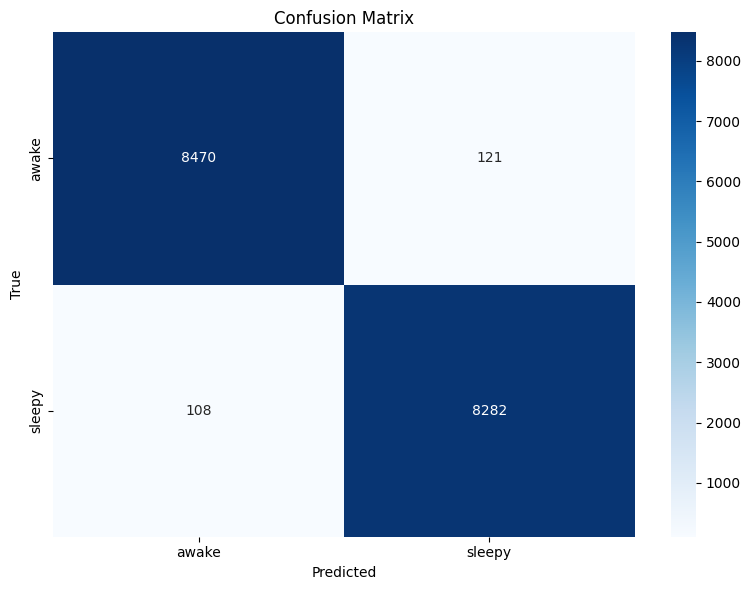

In [18]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [19]:
# Finish the run
wandb.finish()

epoch/accuracy,▁▅▆▇▇███
epoch/epoch,▁▂▃▄▅▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▂▂▁▁▁
epoch/val_accuracy,▁▃▄▆▆█▆▇
epoch/val_loss,█▅▄▃▂▁▄▂
test_accuracy,▁
test_loss,▁
epoch/accuracy,0.98738
epoch/epoch,7
epoch/learning_rate,0.0001
